/home/faraz/opencaret/opencaret/ros/src/perception/src/perception/predict.py:123: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img_variable = Variable(img_tensor, volatile=True)


43965.96407458242


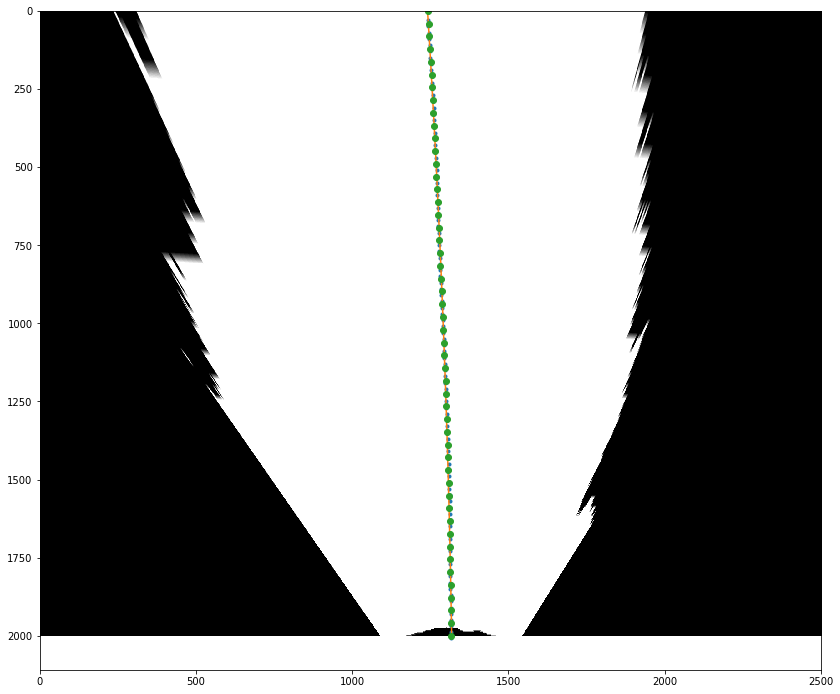

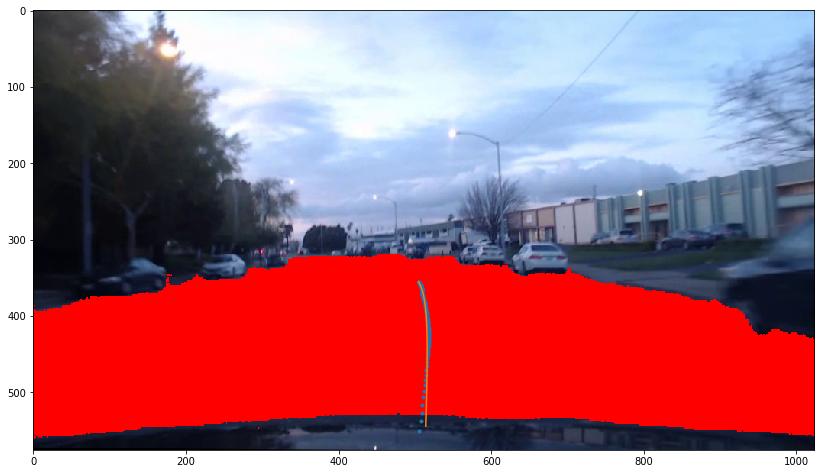

In [337]:
import numpy as np
%matplotlib inline
import perception.predict as predict
from scipy import stats
import matplotlib.pyplot as plt
import cv2 
import pickle
from scipy.interpolate import UnivariateSpline
plt.rcParams['figure.figsize'] = [14, 20]

# cap = cv2.VideoCapture('output.mp4')
cap = cv2.VideoCapture('/home/faraz/data/2019-03-20-192432.webm')
transform = pickle.load(open('road_transform_1536.p','rb'))
(mtx, dist) = pickle.load(open('cam_calib.p','rb'))
weights = "/home/faraz/opencaret/ESPNet/results_enc__dec_2_8/model_331.pth"
predictor = predict.Prediction(model_weights=weights)

for i in range(1320):
    cap.read()

centroids = []

for i in range(1):
    ret, frame = cap.read()
    frame = cv2.undistort(frame, mtx,dist)

    prediction = predictor.infer(frame.astype(np.float32), overlay=False)
    predisp = predictor.infer(frame.astype(np.float32), overlay=True)

    mask = prediction == 0
    prediction[mask] = 255.0
    prediction[~mask] = 0.0
    
#     plt.imshow(prediction, cmap='gray')
#     plt.show()
#     frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)


#     frame = cv2.flip(frame,-1)
#     frame = cv2.resize(frame, (2304, 1536))
    # cv2.imwrite('/home/faraz/data/segout.jpg',frame)
    # h,  w = frame.shape[:2]
    # newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

    # print(transform)    
    # print(frame.shape)
    perspective = cv2.warpPerspective(prediction, transform, (2500,2000))
#     plt.show()
#     plt.show()
    (t, binary) = cv2.threshold(perspective, 50, 255, cv2.THRESH_BINARY)

    

#     frame = cv2.Canny(binary,0,60)
#     frame = cv2.Sobel(perspective, cv2.CV_16S, 1 , 0)
#     frame = cv2.flip(perspective,0) 
    frame = binary
#     print(frame)
#     rightedge = frame < -100
#     leftedge = frame  > 100
#     frame[~rightedge] = 0.0
#     frame[rightedge] = 50.0
#     frame[leftedge] = 50.0
    
#     rightedge[:,0:1250] = False         
#     rightline = np.nonzero(rightedge)
#     plt.imshow(frame, cmap='binary')

    
    
    if len(centroids) > 0:
        average = centroids[0][1]
    else:
        average = None
        
    centroids = []
    for y in range(frame.shape[0], 0, -20):
#         print(frame[y:y+10,:])
        allpoints = np.nonzero(frame[y-20:y,:])
#         print(len(allpoints[1]))
        centroid = centeroidnp(allpoints[1], allpoints[0])
        if average is None:
            average = centroid[0]
        else:
            average = average * 0.99 + centroid[0] * 0.01
            
        centroids.append((centroid[1]+y, average))


    
    centroids = np.array(centroids)
    slope, intercept, r_value, p_value, std_err = stats.linregress(centroids[:,0], centroids[:,1])
    linethrough = np.poly1d(np.polyfit(centroids[:,0], centroids[:,1],2))
    
    spline = UnivariateSpline(np.flip(centroids[:,0]), np.flip(centroids[:,1]), k=2)
    
    x = np.linspace(0,2000)
    y = linethrough(x)
    
    linethroughwarp = np.zeros((x.shape[0],2))
    linethroughwarp[:,1] = x
    linethroughwarp[:,0] = y
    
#     centroids=np.swapaxes(centroids,0,1)
#     print(centroids.shape)
#     centroids[:,0] = frame.shape[0] - (centroids[:,0])
    centroids_swap = centroids.copy()
    centroids_swap[:,[0, 1]] = centroids[:,[1, 0]]
    
    centwarp = cv2.perspectiveTransform(np.array([centroids_swap]), cv2.invert(transform)[1])[0]
    linethroughwarp = cv2.perspectiveTransform(np.array([linethroughwarp]), cv2.invert(transform)[1])[0]
    
    ym_per_pix = 30.0 / 576
    max_y = 576
    print(((1 + (2*linethrough[2]*max_y*ym_per_pix + linethrough[1])**2)**1.5) / np.absolute(2*linethrough[2]))

#     centwarp[:, 1] = 576 - centwarp[:,1]
    plt.imshow(perspective, cmap='gray')
    plt.plot(centroids[:,1], centroids[:, 0], '.', linethrough(x),x , '-', spline(x), x, 'o')
#     plt.xlim(0, 2500)
    plt.show()
    plt.imshow(predisp)
    plt.plot(centwarp[:,0], centwarp[:,1], '.', linethroughwarp[:,0], linethroughwarp[:,1], '-')
    plt.show()
    
    # wheel angle:
#     r = s / (sqrt(2 - 2 * cos(2*a/n)) 

    # Reference https://www.physicsforums.com/threads/steering-wheel-angle-radius-of-curvature.59881/

#     plt.imshow(frame, cmap='binary')
#     plt.show()
cap.release()
